(np_linalg_tutorial)=
# Linear algebra on n-dimensional arrays (ported)

This page is an adaptation of the [Linear algebra on n-dimensional arrays](https://numpy.org/numpy-tutorials/content/tutorial-svd.html) tutorial from the NumPy website.

## Learner profile

This tutorial is for people who have a basic understanding of linear algebra and arrays in NumPy and want to see how this works in `xarray-einstats`.

## Learning Objectives

After this tutorial, you should be able to:

- Understand how to apply some linear algebra operations to DataArrays without using `.values` or `.to_numpy()`;
- Understand how axis and shape properties translate to DataArrays and dims.

## Content

In this tutorial, we will use a [matrix decomposition](https://en.wikipedia.org/wiki/Matrix_decomposition) from linear algebra, the Singular Value Decomposition, to generate a compressed approximation of an image. We'll use the `face` image from the [scipy.datasets](https://docs.scipy.org/doc/scipy/reference/datasets.html) module:

In [1]:
from scipy import datasets
import xarray as xr

xr.set_options(display_expand_data=False)

img = xr.DataArray(datasets.face(), dims=["height", "width", "color"], coords={"color": ["R", "G", "B"]})

:::{note}
If you prefer, you can use your own image as you work through this tutorial. In order to transform your image into a NumPy array that can be manipulated, you can use the `imread` function from the [matplotlib.pyplot](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.html#module-matplotlib.pyplot) submodule. Alternatively, you can use the [imageio.imread](https://imageio.readthedocs.io/en/stable/_autosummary/imageio.v3.imread.html) function from the `imageio` library. Be aware that if you use your own image, you might need to adapt some steps below.
:::

Now, `img` is a xarray DataArray, as we can see when using the `type` function:

In [2]:
type(img)

xarray.core.dataarray.DataArray

We can see the image using {func}`matplotlib.pyplot.imshow`.

In [3]:
import matplotlib.pyplot as plt

%matplotlib inline

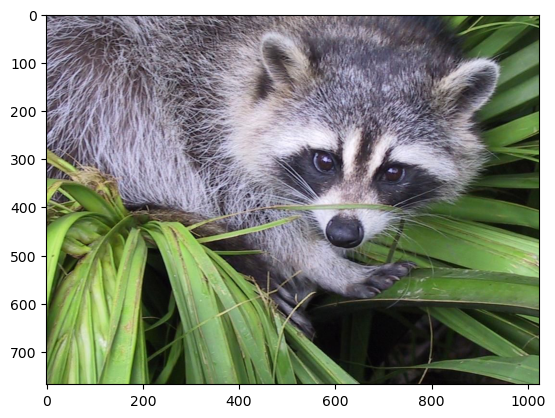

In [4]:
plt.imshow(img)
plt.show()

### Dimensions and DataArray properties
In NumPy arrays, dimensions/axis are identified by their positional order, in xarray DataArrays however, dimensions are identified by their name.

We can use `.dims` to see their names:

In [5]:
img.dims

('height', 'width', 'color')

The output is a [tuple](https://docs.python.org/dev/tutorial/datastructures.html#tut-tuples) with three elements, as we have defined when creating the `img` variable a few cells above.

However, it is generally not very useful to use `.dims` for printing. Xarray objects have rich and informative
text and html output:

In [6]:
img

<xarray.DataArray (height: 768, width: 1024, color: 3)> Size: 2MB
121 112 131 138 129 148 153 144 165 155 ... 98 120 156 95 119 155 93 118 154 92
Coordinates:
  * color    (color) <U1 12B 'R' 'G' 'B'
Dimensions without coordinates: height, width

The first line of the output gives the information we got with `type`, with `.dims` _and_ more: it also indicates the length of each dimension in addition to their name.

The next lines show a preview of the data, and other fields: coordinates, indexes and attributes.
You might have also noticed that in the first line, the color dimension is in bold face unlike the others.
This is because it has coordinates assigned to index that dimension. Therefore, we can use `.sel` with the
labels we defined instead of the position to subset the data:

In [7]:
img.sel(color="R")

<xarray.DataArray (height: 768, width: 1024)> Size: 786kB
121 138 153 155 155 158 159 156 147 137 ... 113 116 117 120 121 121 120 119 118
Coordinates:
    color    <U1 4B 'R'
Dimensions without coordinates: height, width

From the output above, we can see that every value in red color channel of `img` is an integer value between 0 and 255, representing the level of red in each corresponding image pixel (keep in mind that this might be different if you
use your own image instead of [scipy.datasets.face](https://docs.scipy.org/doc/scipy/reference/generated/scipy.datasets.face.html#scipy.datasets.face)).

Note the data subset now has two dimensions only: height and width of lengths 768 and 1024 respectively.

Since we are going to perform linear algebra operations on this data, it might be more interesting to have real numbers between 0 and 1 in each entry of the matrices to represent the RGB values. We can do that by setting

In [8]:
img_array = img / 255

This operation, dividing an array by a scalar, works because of NumPy's and xarray broadcasting. (Note that in real-world applications, it would be better to use, for example, the [img_as_float](https://scikit-image.org/docs/stable/api/skimage.html#skimage.img_as_float) utility function from `scikit-image`).

You can check that the above works by doing some tests; for example, inquiring
about maximum and minimum values for this array:

In [9]:
img_array.max(), img_array.min()

(<xarray.DataArray ()> Size: 8B
 1.0,
 <xarray.DataArray ()> Size: 8B
 0.0)

or checking the type of data in the array:

In [10]:
img_array.dtype

dtype('float64')

### Operations on an axis

It is possible to use methods from linear algebra to approximate an existing set of data. Here, we will use the [SVD (Singular Value Decomposition)](https://en.wikipedia.org/wiki/Singular_value_decomposition) to try to rebuild an image that uses less singular value information than the original one, while still retaining some of its features.

To proceed, import the linear algebra submodule from `xarray-einstats`:

In [11]:
from xarray_einstats import linalg

In order to extract information from a given matrix, we can use the SVD to obtain 3 arrays which can be multiplied to obtain the original matrix. From the theory of linear algebra, given a matrix $A$, the following product can be computed:

$$U \Sigma V^T = A$$

where $U$ and $V^T$ are square and $\Sigma$ is the same size as $A$. $\Sigma$ is a diagonal matrix and contains the [singular values](https://en.wikipedia.org/wiki/Singular_value) of $A$, organized from largest to smallest. These values are always non-negative and can be used as an indicator of the "importance" of some features represented by the matrix $A$.

Let's see how this works in practice with just one matrix first. Note that according to [colorimetry](https://en.wikipedia.org/wiki/Grayscale#Colorimetric_(perceptual_luminance-reserving)_conversion_to_grayscale),
it is possible to obtain a fairly reasonable grayscale version of our color image if we apply the formula

$$Y = 0.2126 R + 0.7152 G + 0.0722 B$$

where $Y$ is the array representing the grayscale image, and $R$, $G$ and $B$ are the red, green and blue channel arrays we had originally. Notice we can use a dot product for this:

In [12]:
color_coefs = xr.DataArray([0.2126, 0.7152, 0.0722], dims=["color"], coords={"color": ["R", "G", "B"]})
img_gray = img_array.dot(color_coefs)

Now, `img_gray` has shape

In [13]:
img_gray

<xarray.DataArray (height: 768, width: 1024)> Size: 6MB
0.4521 0.5188 0.5782 0.586 0.586 0.5955 ... 0.5667 0.5662 0.5645 0.5603 0.5564
Dimensions without coordinates: height, width

To see if this makes sense in our image, we should use a colormap from `matplotlib` corresponding to the color we wish to see in out image (otherwise, `matplotlib` will default to a colormap that does not correspond to the real data).

In our case, we are approximating the grayscale portion of the image, so we will use the colormap `gray`:

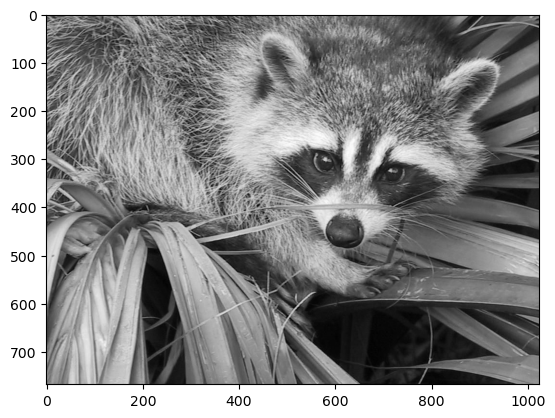

In [14]:
plt.imshow(img_gray, cmap="gray");

Now, applying the [linalg.svd](https://numpy.org/devdocs/reference/generated/numpy.linalg.svd.html#numpy.linalg.svd) function to this matrix, we obtain the following decomposition:

In [15]:
U, s, Vt = img_gray.linalg.svd(dims=["height", "width"])

:::{attention}
If you are using your own image, this command might take a while to run, depending on the size of your image and your hardware. Don't worry, this is normal! The SVD can be a pretty intensive computation.
:::

Let's check that this is what we expected:

In [16]:
U

<xarray.DataArray (height: 768, height2: 768)> Size: 5MB
0.03181 0.01899 0.01773 0.00738 0.01887 ... 0.03089 0.005258 0.0146 0.004079
Dimensions without coordinates: height, height2

In [17]:
s

<xarray.DataArray (height: 768)> Size: 6kB
410.4 85.56 63.61 45.85 41.97 38.26 ... 0.01117 0.01085 0.01079 0.01032 0.009925
Dimensions without coordinates: height

In [18]:
Vt

<xarray.DataArray (width: 1024, width2: 1024)> Size: 8MB
0.03587 0.03582 0.03581 0.03574 0.03553 ... 0.03706 0.0731 -0.2073 0.1374
Dimensions without coordinates: width, width2

Note that `s` has a particular shape: it has only one dimension. This means that some linear algebra functions that expect 2d arrays might not work. For example, from the theory, one might expect `s` and `Vt` to be
compatible for multiplication. However, this is not true as `s` does not have a second axis, and we don't want to execute a dot product as that would multiply the elements in `s` for whole columns instead of a matrix multiplication.

This happens because having a one-dimensional array for `s`, in this case, is much more economic in practice than building a diagonal matrix with the same data. To reconstruct the original matrix, we can rebuild the diagonal matrix $\Sigma$ with the elements of `s` in its diagonal and with the appropriate dimensions for multiplying: in our case, $\Sigma$ should have `height, width` dimensions. In order to add the singular values to the diagonal of `Sigma`, we will manually create the indexes and use `.loc`:

In [19]:
import numpy as np

Sigma = xr.zeros_like(img_gray)
idx = xr.DataArray(np.arange(min(Sigma.shape)), dims="pointwise_sel")
Sigma.loc[{"width": idx, "height": idx}] = s.rename(height="pointwise_sel")

In [20]:
Sigma

<xarray.DataArray (height: 768, width: 1024)> Size: 6MB
410.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: height, width

Now, we want to check if the reconstructed `U @ Sigma @ Vt` is close to the original `img_gray` matrix.

## Approximation

The {mod}`.linalg` module includes a {func}`.linalg.norm` function, which computes the norm of a vector or matrix represented in a NumPy array. For example, from the SVD explanation above, we would expect the norm of the difference between `img_gray` and the reconstructed SVD product to be small. As expected, you should see something like

In [21]:
approx = linalg.matmul(
    linalg.matmul(U, Sigma, dims=[["height", "height2"], ["height", "width"]]),
    Vt,
    dims=["height", "width", "width2"],
).rename(width2="width")
linalg.norm(img_gray - approx, dims=("height", "width"))

<xarray.DataArray ()> Size: 8B
1.386e-12

(The actual result of this operation might be different depending on your architecture and linear algebra setup. Regardless, you should see a small number.)

We could also have used the [numpy.allclose](https://numpy.org/devdocs/reference/generated/numpy.allclose.html#numpy.allclose) function to make sure the reconstructed product is, in fact, *close* to our original matrix (the difference between the two arrays is small):

In [22]:
np.allclose(img_gray, approx)

True

To see if an approximation is reasonable, we can check the values in `s`:

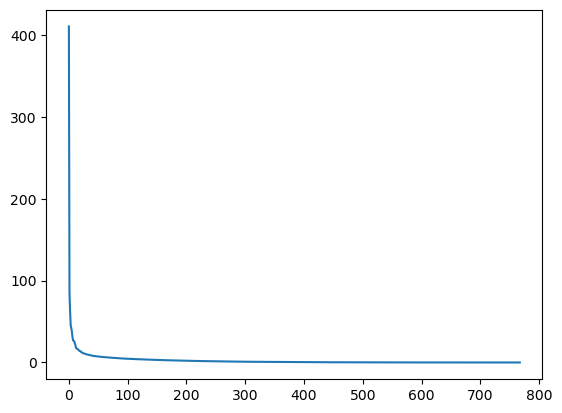

In [23]:
plt.plot(s)
plt.show()

In the graph, we can see that although we have 768 singular values in `s`, most of those (after the 150th entry or so) are pretty small. So it might make sense to use only the information related to the first (say, 50) *singular values* to build a more economical approximation to our image.

The idea is to consider all but the first `k` singular values in `Sigma` (which are the same as in `s`) as zeros, keeping `U` and `Vt` intact, and computing the product of these matrices as the approximation.

For example, if we choose

In [24]:
k = 10

In [25]:
Sigma.sel(width=slice(0, k))

<xarray.DataArray (height: 768, width: 10)> Size: 61kB
410.4 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0
Dimensions without coordinates: height, width

In [26]:
Vt.sel(width=slice(0, k))

<xarray.DataArray (width: 10, width2: 1024)> Size: 82kB
0.03587 0.03582 0.03581 0.03574 0.03553 ... -0.07889 -0.07779 -0.07644 -0.07542
Dimensions without coordinates: width, width2

we can build the approximation by doing

In [27]:
approx = linalg.matmul(
    linalg.matmul(U, Sigma.sel(width=slice(0, k)), dims=[["height", "height2"], ["height", "width"]]),
    Vt.sel(width=slice(0, k)),
    dims=["height", "width", "width2"],
).rename(width2="width")

Note that we had to use only the first `k` rows of `Vt`, since all other rows would be multiplied by the zeros corresponding to the singular values we eliminated from this approximation.

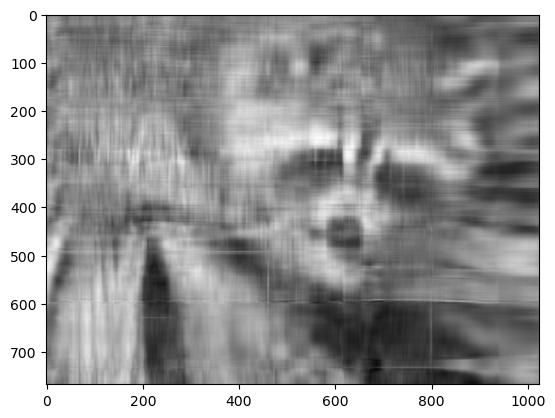

In [28]:
plt.imshow(approx, cmap="gray")
plt.show()

Now, you can go ahead and repeat this experiment with other values of `k`, and each of your experiments should give you a slightly better (or worse) image depending on the value you choose.

### Applying to all colors

Now we want to do the same kind of operation, but to all three colors. Our first instinct might be to repeat the same operation we did above to each color matrix individually. However, `xarray-einstats` will take care of all this for us (using NumPy's and xarray's *broadcasting* under the hood).

Unlike with raw NumPy where we need to be careful to place the dimensions we want to operate on in the first or last position, with `xarray-einstats` we indicate the dimensions we want to operate on using the `dims` argument.
That was quite an overkill so far as the inputs where 2d, yet we still specified which dimensions we wanted to operate on. But the good news come now, nearly everything we have done so far works just the same if we include the color channel too, with no changes, no transposing, no indicating we now have more dimensions... we were operating on the height and width dimensions, so `xarray-einstats` will do so whether they are the only dimensions or the 3rd and 7th out of a total of 9 dimensions.

In [29]:
U, s, Vt = img_array.linalg.svd(dims=["height", "width"])

Finally, to obtain the full approximated image, we need to reassemble these matrices into the approximation.

### Products with n-dimensional arrays

Here is the only modified piece of code: the creation of the `Sigma` matrix.

In [30]:
# modified code
Sigma = xr.zeros_like(img_array)
min_len = min(len(Sigma["height"]), len(Sigma["width"]))
idx = xr.DataArray(np.arange(min_len), dims="height")

Sigma.loc[{"height": idx, "width": idx}] = s.transpose()  # the transpose is a workaround due to https://github.com/pydata/xarray/issues/7030

Now, if we wish to rebuild the full SVD (with no approximation), we can do

In [31]:
reconstructed = linalg.matmul(
    linalg.matmul(U, Sigma, dims=[["height", "height2"], ["height", "width"]]),
    Vt,
    dims=["height", "width", "width2"],
).rename(width2="width")
reconstructed

<xarray.DataArray (color: 3, height: 768, width: 1024)> Size: 19MB
0.4745 0.5412 0.6 0.6078 0.6078 0.6196 ... 0.3922 0.3843 0.3725 0.3647 0.3608
Coordinates:
  * color    (color) <U1 12B 'R' 'G' 'B'
Dimensions without coordinates: height, width

The reconstructed image should be indistinguishable from the original one, except for differences due to floating point errors from the reconstruction. Recall that our original image consisted of floating point values in the range `[0., 1.]`. The accumulation of floating point error from the reconstruction can result in values slightly outside this original range:

In [32]:
reconstructed.min(), reconstructed.max()

(<xarray.DataArray ()> Size: 8B
 -5.056e-15,
 <xarray.DataArray ()> Size: 8B
 1.0)

Since `imshow` expects values in the range, we can use `clip` to excise the floating point error:

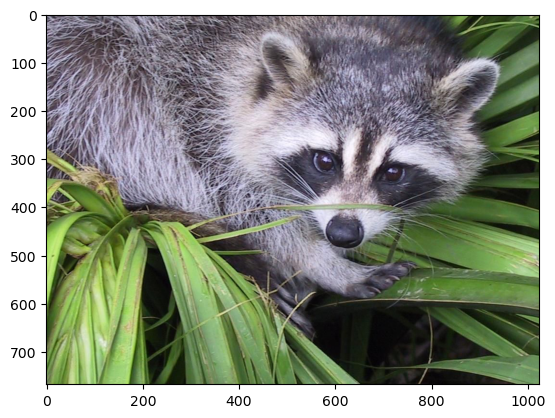

In [33]:
reconstructed = np.clip(reconstructed, 0, 1)
plt.imshow(reconstructed.transpose(..., "color"));

In fact, `imshow` peforms this clipping under-the-hood, so if you skip the first line in the previous code cell, you might see a warning message saying `"Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)."`

Now, to do the approximation, we must choose only the first `k` singular values for each color channel. This can be done using the following syntax:

In [34]:
approx = linalg.matmul(
    linalg.matmul(U, Sigma.sel(width=slice(0, k)), dims=[["height", "height2"], ["height", "width"]]),
    Vt.sel(width=slice(0, k)),
    dims=["height", "width", "width2"],
).rename(width2="width")

You can see that we have selected only the first `k` components of the last axis for `Sigma` (this means that we have used only the first `k` columns of each of the three matrices in the stack), and that we have selected only the first `k` components in the second-to-last axis of `Vt` (this means we have selected only the first `k` rows from every matrix in the stack `Vt` and all columns). If you are unfamiliar with the ellipsis syntax, it is a
placeholder for other axes. For more details, see the documentation on [Indexing](https://numpy.org/devdocs/user/basics.indexing.html#basics-indexing).

Now,

In [35]:
approx

<xarray.DataArray (color: 3, height: 768, width: 1024)> Size: 19MB
0.4745 0.4822 0.4893 0.492 0.4967 0.5061 ... 0.2838 0.2866 0.2899 0.2925 0.2938
Coordinates:
  * color    (color) <U1 12B 'R' 'G' 'B'
Dimensions without coordinates: height, width

which is not the right shape for showing the image. We need to place the color dimension as last to be able to plot with matplotlib:

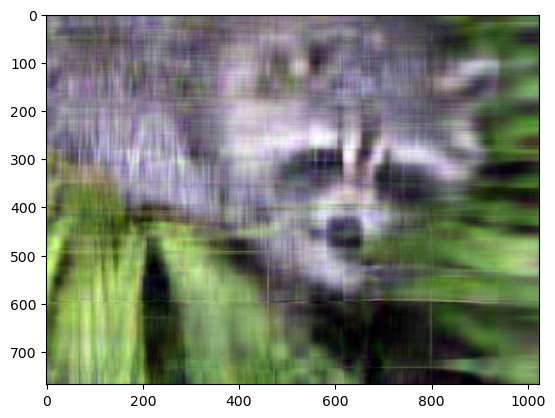

In [36]:
approx = np.clip(approx, 0, 1)
plt.imshow(approx.transpose(..., "color"));

Even though the image is not as sharp, using a small number of `k` singular values (compared to the original set of 768 values), we can recover many of the distinguishing features from this image.

### Final words

Of course, this is not the best method to *approximate* an image. However, there is, in fact, a result in linear algebra that says that the approximation we built above is the best we can get to the original matrix in
terms of the norm of the difference. For more information, see *G. H. Golub and C. F. Van Loan, Matrix Computations, Baltimore, MD, Johns Hopkins University Press, 1985*.

## Further reading

-  [Python tutorial](https://docs.python.org/dev/tutorial/index.html)
-  [NumPy Reference](https://numpy.org/devdocs/reference/index.html#reference)
-  [SciPy Tutorial](https://docs.scipy.org/doc/scipy/tutorial/index.html)
-  [SciPy Lecture Notes](https://scipy-lectures.org)
-  [A matlab, R, IDL, NumPy/SciPy dictionary](http://mathesaurus.sf.net/)

In [37]:
%load_ext watermark
%watermark -n -u -v -iv -w

Last updated: Thu, 19 Feb 2026

Python implementation: CPython
Python version       : 3.13.9
IPython version      : 9.7.0

matplotlib     : 3.10.8
numpy          : 2.3.5
scipy          : 1.16.3
xarray         : 2025.11.0
xarray_einstats: 0.10.0

Watermark: 2.6.0

